# Baseline Model

This is a simple baseline model that uses the relative frequency of a MeSH term's occurrence in a document's references in order to decide whether to apply that particular MeSH term to the document. MeSH term counts (and consequently relative frequencies) were determined by mining PMC full-texts to extract as many of a particular document's references as possible. MeSH terms were then counted for each of these references, summed, and divided by the total to give the relative frequency that each term was applied to the original document's references. This is all detailed in the notebook [data_aggregation_pipeline.ipynb](https://github.com/wigasper/FUSE/blob/master/data_aggregation_pipeline.ipynb), or in the original Python files in the [data-aggregation directory](https://github.com/wigasper/FUSE/tree/master/data-aggregation).

For the model, I selected a series of threshold values starting at 0 and increasing up to 1. For each threshold, for each document in the dataset, if a term's frequency among the document's references exceeds the threshold, I predict that the term will be applied to the document.

This model serves as a basis for evaluation for future, more complex, models.

Throughout this process I've utilized lists and dictionaries as my primary data structures, and stored them on disk as JSON formatted files. This, in general, has turned out to be a good decision. A lot of this process requires millions of lookups on what would otherwise be an extremely large, sparse table. Using dictionaries rather than a matrix or Pandas DF speeds up this process immensely - this simple model takes less than a minute to run (faster than it takes just to load in the data using Pandas) and scales efficiently. It also takes up significantly less space on disk: the JSON file for the term frequency data is 83.5 MB, while storing as table in csv format takes up 448.8 MB. 

In [1]:
import json

from sklearn.metrics import auc
from matplotlib import pyplot

# Load in term frequencies
with open("./data/term_freqs.json", "r") as handle:
    term_freqs = json.load(handle)

# Load in solution values
with open("./data/baseline_solution.json", "r") as handle:
    solution = json.load(handle)

# Dict to store predictions and lists to store evaluation metrics
predictions = {}
precisions = []
recalls = []
f1s = []

Next I generate a list of thresholds to test, starting at 0 and going to 1 in increments of .005.

In [2]:
thresholds = [x * .005 for x in range(0,200)]

Run the model for all thresholds, calculate evaluation metrics as each threshold is tested and record.

In [6]:
# Run the model for all thresholds
for thresh in thresholds:
    # Predict
    for doc in term_freqs:
        predictions[doc[0]] = [key for key, val in doc[1].items() if val > thresh]
        
    # Get evaluation metrics
    true_pos = 0
    false_pos = 0
    false_neg = 0
    
    for pmid in predictions:
        true_pos += len([pred for pred in predictions[pmid] if pred in solution[pmid]])
        false_pos += len([pred for pred in predictions[pmid] if pred not in solution[pmid]])
        false_neg += len([sol for sol in solution[pmid] if sol not in predictions[pmid]])

    # Avoid a ZeroDivisionError if precision and recall are both 0
    if true_pos == 0:
        precision = 0
        recall = 0
        f1 = 0
    else:
        precision = true_pos / (true_pos + false_pos)
        recall = true_pos / (true_pos + false_neg)
        f1 = (2 * precision * recall) / (precision + recall)
    
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)

In [4]:
# Calculate AUC
print("AUC: ", auc(recalls, precisions))

AUC:  0.3974255073464244


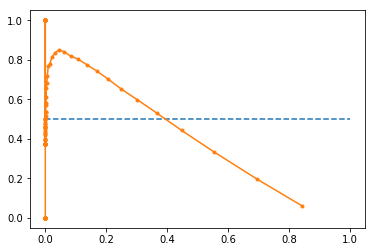

In [5]:
# Plot PR curve
pyplot.plot([0, 1], [0.5, 0.5], linestyle="--")
pyplot.plot(recalls, precisions, marker=".")
pyplot.savefig("../pr_curve.png")
pyplot.show()

AUC and the PR curve are both reasonable for a simple, baseline model. The curve does appear to be a little off compared to other PR curves, and there are a couple reasons for this:
1. Recall never hits 1.0 because documents often have terms applied to them that were not applied to any of their references. I try to improve on this in future models by incorporating semantic similarity of terms into the predictive process.
2. Precision decreases as recall approaches 0, but there is also a point where precision hits 1 - this is because of a handful of uncharacteristic documents that only have a few references.